# Proposing new configurations in Monte Carlo simulations using truncated Markov Chains - Branched Molecules

## Table of Contents
1. [Routines, dependencies and packages](#Functions)
2. [Main - Generation of the sampling](#Algorithms) <br />
    2.1 [Generate the sampling](#GenSamp)  <br />
    2.2 [Target distribution - Sampling](#TargetSampling)<br />
    2.3 [Prior distributions - Sampling](#PriorSampling)<br />
    2.4 [Asymptotic distributions - Sampling](#Asymptotic)<br />
    2.5 [Comparison TMCMC and Asymptotic](#CompTMCMCAS)<br />
3. [Figures](#Figures)<br />
    3.1 [Figure 4](#Fig4)<br />
    3.2 [Figure P_gen BM2](#FigPgenBM2)<br />
    3.3 [Figure P_gen BM3](#FigPgenBM3)<br />

## 1. Routines, dependencies and packages <a name="Functions"></a>

Install packages.

In [2]:
pip install numpy-quaternion

Import dependencies.

In [1]:

import numpy as np
import scipy as sp
import os
import errno
import quaternion as quat
from pylab import show,hist,subplot,figure 
from numpy import linalg as nla
import matplotlib.pyplot as plt
from matplotlib import pyplot
from copy import copy, deepcopy
import scipy.stats as stats
from matplotlib import gridspec
import matplotlib.font_manager as font_manager
import matplotlib.offsetbox
from matplotlib.lines import Line2D
import matplotlib.image as mpimg

# use latex for font rendering
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['text.usetex'] = True

Define the routines.

In [2]:
# Parameters of the model
nbranches = 2 # Number of branches to regrow (total = nbranches + 1)
k = 62500 / 300

if nbranches == 2:
    theta0 = 112/180*np.pi
if nbranches == 3:
    theta0 = 109.47/180*np.pi


def extractKBits(num,k,p): 
    """Return an integer

    Extract ‘k’ bits at a given position 'p' of the binary representation of 'num'
    adapted from https://www.geeksforgeeks.org/python-slicing-extract-k-bits-given-position/
    """
    # convert number into binary first 
    binary = bin(num) 

    # remove first two characters 
    binary = binary[2:] 

    end = len(binary) - p 
    start = end - k + 1

    # extract k  bit sub-string 
    kBitSubStr = binary[start : end+1] 

    # convert extracted sub-string into decimal again 
    return int(kBitSubStr,2)




def prior_prob(x):
    """Return a float

    Compute the prior distribution \pi_0(x)
    """
    priorprob = 1
    for i in range(1,len(x)):
        theta=np.arccos(np.dot(x[0],x[i]))
        priorprob*=np.exp(-k*(theta-theta0)**2)    
    return priorprob


def sample_prior(nb):
    """Return a (nb,ndim)-dimensional array of float

    Generate an array distributed as prior_prob() using the rejection method
    """
    v = np.zeros((nb+1,3))
    v[0,0] = 1
    for i in range(1,nb+1):
        v[i] = random_unit_vector()
    for i in range(nb):
        while rejection(v[0],v[i+1]) == True :
            v[i+1] = random_unit_vector()
    return v


def rejection(v1,v2):
    """Return a bool

    Rejection method
    """
    theta = np.arccos(np.dot(v1,v2))
    h = np.random.uniform(0,1)
    return (h > Ptheta(theta))
    
    
def Ptarg(x):
    """Return a float

    Compute the target distribution P_T(x)
    """
    Ptarg = 1
    for i in range(len(x)):
        for j in range(i+1,len(x)):
            theta=np.arccos(np.dot(x[i],x[j]))
            Ptarg*=np.exp(-k*(theta-theta0)**2)    
    return Ptarg

def Ptarg_log(x):
    """Return a float

    Compute the logarithm of target distribution P_T(x)
    """
    Ptarglog = 0
    for i in range(len(x)):
        for j in range(i+1,len(x)):
            theta=np.arccos(np.dot(x[i],x[j]))
            Ptarglog+=-k*(theta-theta0)**2   
    return Ptarglog
    

def Energy(x):
    """Return a float

    Compute the energy of the state x
    """
    Energy = 0
    for i in range(len(x)):
        for j in range(i+1,len(x)):
            theta = np.arccos(np.dot(x[i],x[j]))
            Energy += k*(theta-theta0)**2
    
    return Energy


def Ptheta(theta):
    """Return a float

    Compute the exponential of -k(theta-theta_0)^2
    """
    return np.exp(-k*(theta-theta0)**2)

def acc(x,y):
    """Return two floats

    Compute the acceptance acc(x->y) using Metropolis 
    Return 1) Jxx = 1-acc(x->y), 2) Jxx = acc(x->y)
    """
    Plognew=Ptarg_log(y)
    Plogold=Ptarg_log(x)
    
    if Plognew > Plogold:
        Jxy = 1.
    else:
        if np.abs(Plognew-Plogold)>100:
            Jxy = 0.
        else:
            lnJxy = Plognew-Plogold
            Jxy = np.exp(lnJxy)

    Jxx=1.-Jxy  
    return Jxx, Jxy




def f(x,y,px,py,Dangle,rotaxis,rotindex):
    """Return three floats and one integer

    Configuration at layer i+1: y (=x+Dx)
    Configurations at layer i: y and x (prior prababilities py and px)
    The function samples between y and x at layer i
    Return: 1) the probability of y at layer i+1, 
            2) Jxy = acc(x->y),
            3) Jyy = 1-acc(y->y+Dx),
            4) new = 1 (0) if at layer i x (y) is selected
    """
    z = rotation(deepcopy(y),rotindex,Dangle,rotaxis)
    Jxx, Jxy = acc(x,y)
    Jyy, Jyz = acc(y,z)
    newpy=px*Jxy+py*Jyy

    rnd=np.random.rand(1)
    if newpy == 0:
        new=0
    else:
        if(rnd[0]<px*Jxy/newpy):
            new=1
        else:
            new=0
    return newpy, Jxy,Jyy, new

def generate_y(n,nbranches,DangleVec,rotindexVec,rotaxisVec): 
    """Return two (nb,ndim)-dimensional arrays of floats and an array of n integers

    The function generates a new optimized configuration ynew 
    Return: 1) The new configuration ynew = y0 + VecEta_i * dxVec_i
            2) The generating probability  P_gen(ynew) = \pi_0(y_0)*\prod_{i=0}^{n-1}f(y_{i}->y_{i+1})
            3) The list of accepted/rejected moves {\eta}: 
                \eta_i = 1 (0) if the move y_{i} -> y_{i}+dxVec_i is accepted (rejected)
    """
    
     # The list of accepted/rejected moves {\eta}
    VecEta=np.array([])
    
    # Generates the initial state (x=y0) in the first layer 
    x=sample_prior(nbranches)
    
    # Initialise the probability of the trajectory
    prob=prior_prob(x)

    
    ilayer=0
    while(ilayer<n):
        y=rotation(deepcopy(x),rotindexVec[ilayer],DangleVec[ilayer],rotaxisVec[ilayer])
        
        # Compute the acceptance
        accxx, accxy = acc(x,y)

        
        rnd=np.random.rand(1)
        if(rnd[0]<accxy):
            x=deepcopy(y)
            prob=prob*accxy  
            
            # 16/07-2
            VecEta=np.append(VecEta,1)
            
        else:
            prob=prob*accxx    
            
            # 16/07-2
            VecEta=np.append(VecEta,0)
            
        ilayer=ilayer+1
    
    return x, prob, VecEta

def regenerate_y(y0,n,nbranches,dangleVec,rotindexVec,rotaxisVec):    
    """Return a float

    Return the tree (or full) probability of yn as used in Algorithm alphaB
    """
    # n2n is the number of trajectories ending in yn
    n2n=np.power(2,n)
    
    # Initalisation of x0Vec, the array of the 2^n states in the first layer that connected to x^n 
    # with a combination of dxVec and eta's
    x0Vec=np.ones((n2n,nbranches+1,3))
    for i in range(0,n2n):
        x0Vec[i]=deepcopy(y0)
    
    ix0=0
    while(ix0<n2n):
        acn=n2n+ix0
        ibit=n
        while(ibit>0):
            acb=extractKBits(acn,1,ibit)
            x0Vec[ix0]=rotation(deepcopy(x0Vec[ix0]),rotindexVec[ibit-1],-acb*dangleVec[ibit-1],rotaxisVec[ibit-1])
            ibit=ibit-1

        ix0=ix0+1

    # Running posteriori probabilities 
    piVec=np.zeros(n2n) 
    fluxVec=np.zeros(n2n)

    ix0=0
    while(ix0<n2n):
        piVec[ix0]=prior_prob(x0Vec[ix0])
        ix0=ix0+1
    
    ilayer=0
    while(ilayer<n):
        dnx=np.power(2,ilayer)
        dny=np.power(2,ilayer+1)
        ix0=0

        while(ix0<n2n):
            y=deepcopy(x0Vec[ix0])
            x=deepcopy(x0Vec[ix0+dnx])
            py=piVec[ix0]
            px=piVec[ix0+dnx]        
            newpy, Jxy, Jyy, new = f(x,y,px,py,dangleVec[ilayer],rotaxisVec[ilayer],rotindexVec[ilayer])                            
            piVec[ix0]=newpy
            
            if(new==1):
                fluxVec[ix0]=fluxVec[ix0+dnx]*Jxy 
            else:
                fluxVec[ix0]=fluxVec[ix0]*Jyy
            
            ix0=ix0+dny

        ilayer=ilayer+1
    
    return piVec[0], fluxVec[0]

def regenerate_2_y(y0,n,nbranches,dangleVec,rotindexVec,rotaxisVec,VecEta):     
    """Return a float

    Return the probability of the trajectory {(dTheta,rotindex,rotaxis), VecEta} ending in yn as used in Algorithm alphaA
    """
    # Obtain the n+1 states of the trajectory (dxVec, eta) ending in yn 
    Vec_y0=np.zeros((n+1,nbranches+1,3))
    Vec_y0[n]=y0
    ip=n-1
    
    while(ip>=0):
        Vec_y0[ip]=rotation(deepcopy(Vec_y0[ip+1]),rotindexVec[ip],-VecEta[ip]*dangleVec[ip],rotaxisVec[ip])
        ip=ip-1
            
    # Compute the probability of the trajectory 
    prob=prior_prob(Vec_y0[0])
    
    ip=0
    while(ip<n):
        x=deepcopy(Vec_y0[ip])
        y=rotation(deepcopy(Vec_y0[ip]),rotindexVec[ip],dangleVec[ip],rotaxisVec[ip])
        Jyy, Jxy = acc(x,y)
        if(VecEta[ip] == 1):
            prob=prob*Jxy
        else:
            prob=prob*Jyy        
        ip=ip+1

    return prob

def generate_dxVec(n,dxVec,dxMax): 
    """Return a n-dim array of floats

    The function generates the n displacements
    """
    ilayer=0
    rnd=np.random.rand(n)
    while(ilayer<n):
        dxVec[ilayer]=dxMax*(2*rnd[ilayer]-1.)
        ilayer=ilayer+1
    return dxVec

def random_unit_vector():
    """Return a ndim-dimensional array of float

    Generate a random unit vector using the method of the angles
    """
    v = np.zeros(3)
    phi = np.random.uniform(0,2*np.pi)
    costheta = 1-2*np.random.uniform()
    theta = np.arccos( costheta )
    v[0] = np.sin( theta) * np.cos( phi )
    v[1] = np.sin( theta) * np.sin( phi )
    v[2] = np.cos( theta )
    return v

def random_unit_vector_1():
    """Return a ndim-dimensional array of float

    Generate a random unit vector using the method of the cube
    """
    v = 2*np.random.uniform(0,1,3)-1
    while v[0]**2+v[1]**2+v[2]**2>1:
        v = 2*np.random.uniform(0,1,3)-1 
    return v/np.sqrt(v[0]**2+v[1]**2+v[2]**2)



def rotation(v,index, angle, axis):
    """Return a (nb,ndim)-dimensional array of float

    Rotate the vector v[index] by an angle "angle" around the axis "axis"
    """
    vnew = deepcopy(v)
    vector = np.array([0.] + vnew[index])
    rot_axis = np.array([0.] + axis)
    axis_angle = (angle*0.5) * rot_axis
    vec = quat.quaternion(*vnew[index])
    qlog = quat.quaternion(*axis_angle)
    q = np.exp(qlog)
    v_prime = q * vec * np.conjugate(q)
    vnew[index] = v_prime.imag
    return vnew


## 2. Main <a name="Algorithms"></a>

###### 2.1 Generate the sampling <a name="GenSamp"></a>

In [19]:
# Parameters of the algorithm

n=3
NMC=10000
dangleMax=90.0*np.pi/180#/np.sqrt(n)

# Choice of algorithm
AlgoA = 1
AlgoB = 0




# Definition of the variables
dangleVec=np.zeros(n) #Vector with the rotation angles
rotaxisVec = np.zeros((n,3)) #Vector with the rotation axes

numberofangles = np.int((nbranches+1)*nbranches/2)
ThetaMat = np.zeros((numberofangles,NMC)) #Matrix with the generated angles
ThetaMatnew = np.zeros((numberofangles,NMC)) #Matrix with the proposed configurations
zstats = np.zeros((5,NMC)) #Statistics of z

iMC=0 # Number of iterations
accrate=0  # Rate of accepted new states
rate0 = 0


# Generate the first serie of displacements
rotindexVec= np.random.randint(1,nbranches+1,n) #Index of the vector to be rotated in each layer
dangleVec=generate_dxVec(n,dangleVec,dangleMax) #Rotation angle vector

for i in range(0,n):
    rotaxisVec[i]=random_unit_vector() #Rotation angle vector


# Generate the first state
y, prob, VecEta = generate_y(n,nbranches, dangleVec,rotindexVec,rotaxisVec)



print('starting y=', y, 'starting prob=', prob)

print('dangleVec=', dangleVec)

print('Eta=', VecEta)




while(iMC<NMC):  
    
    # Generate a new displacement
    rotindexVec= np.random.randint(1,nbranches+1,n) 
    dangleVec=generate_dxVec(n,dangleVec,dangleMax) 
    for i in range(0,n):
        rotaxisVec[i]=random_unit_vector() 
      

    # Algorithm A : 
    if AlgoA == 1:
        # Generate ynew and compute Pgen(ynew)
        ynew, probtrajnew, VecEta = generate_y(n,nbranches,dangleVec,rotindexVec,rotaxisVec)
        # Generate a random set for eta_old
        VecEtaold = np.random.randint(0,2,n)
        # Compute the prob along the eta_old
        probtrajold = regenerate_2_y(deepcopy(y),n,nbranches,dangleVec,rotindexVec,rotaxisVec,VecEta)
        
        probold = probtrajold 
        probnew = probtrajnew
        
        # Record the state
        ind = 0
        for i in range(nbranches+1):
            for j in range(i+1,nbranches+1):
                ThetaMatnew[ind, iMC]=np.arccos(np.dot(ynew[i],ynew[j]))
                ind += 1 
                
        name = 'BM%g_AlgoA_NMC=%g_dxMax=%g_n=%g' % (nbranches,NMC,dangleMax,n)
    
    # Algorithm B : 
    if AlgoB == 1:
        # Generate ynew and compute Pgen(ynew)
        ynew, probtrajnew, VecEta = generate_y(n,nbranches,dangleVec,rotindexVec,rotaxisVec)
        # Compute the probability of the tree leading to ynew
        probtreenew, probtrajnew = regenerate_y(deepcopy(ynew),n,nbranches,dangleVec,rotindexVec,rotaxisVec)
        # Compute the probability of the tree leading to yold
        probtreeold, probtrajold = regenerate_y(deepcopy(y),n,nbranches,dangleVec,rotindexVec,rotaxisVec)

        probold = probtreeold 
        probnew = probtreenew
        
                
        # Record the state
        ind = 0
        for i in range(nbranches+1):
            for j in range(i+1,nbranches+1):
                ThetaMatnew[ind, iMC]=np.arccos(np.dot(ynew[i],ynew[j]))
                ind += 1 
        
        name = 'BM%g_AlgoB_NMC=%g_dxMax=%g_n=%g' % (nbranches,NMC,dangleMax,n)

    #Metropolis   
    Plognew=Ptarg_log(ynew)
    Plogold=Ptarg_log(y)
    
    if np.abs(Plognew-Plogold)>100: 
        if Plognew > Plogold:
            testacc = 1.
        else:
            testacc = 0.
            rate0+= 1
    else:
        lnPTnewoverold = Plognew-Plogold
        PTnewoverold = np.exp(lnPTnewoverold)
        testacc= PTnewoverold*probold/probnew 
        

    rnd = np.random.rand(1)
    if(rnd[0]<testacc):
        y=deepcopy(ynew)
        accrate=accrate+1

    # Record the state
    ind = 0
    for i in range(nbranches+1):
        for j in range(i+1,nbranches+1):
            ThetaMat[ind, iMC]=np.arccos(np.dot(y[i],y[j]))
            ind += 1 

    zstats[0,iMC] = probold 
    zstats[1,iMC] = probnew
    zstats[2,iMC] = Plogold
    zstats[3,iMC] = Plognew
    zstats[4,iMC] = probtrajold


    if(np.mod(iMC*10,NMC)==0):
        print('Number of iterations: ',iMC, 'Acceptance rate:',accrate/(iMC+1))
    

    iMC=iMC+1



print('Taux d\'acceptance:',accrate/NMC)


starting y= [[ 1.          0.          0.        ]
 [-0.0303942  -0.07639459 -0.9966143 ]
 [-0.01631185 -0.99981582  0.01011204]] starting prob= 0.8978657021020736
dangleVec= [-0.49219798  0.78236983 -1.00663412]
Eta= [1. 0. 1.]
Number of iterations:  0 Acceptance rate: 0.0
Number of iterations:  1000 Acceptance rate: 0.04795204795204795
Number of iterations:  2000 Acceptance rate: 0.05547226386806597
Number of iterations:  3000 Acceptance rate: 0.0639786737754082
Number of iterations:  4000 Acceptance rate: 0.061734566358410396
Number of iterations:  5000 Acceptance rate: 0.0635872825434913
Number of iterations:  6000 Acceptance rate: 0.06715547408765206
Number of iterations:  7000 Acceptance rate: 0.0658477360377089
Number of iterations:  8000 Acceptance rate: 0.06411698537682789
Number of iterations:  9000 Acceptance rate: 0.06432618597933563
Taux d'acceptance: 0.0643


In [20]:
# Save the sampling
path = os.getcwd()
try:
    os.makedirs(path+'/data/')
    os.makedirs(path+'/plots/')
except OSError as exc: # Python >2.5
    if exc.errno == errno.EEXIST and os.path.isdir(path):
        pass
    else: raise

np.save('data/'+name+'_ThetaMat', ThetaMat)
np.save('data/'+name+'_ThetaMatnew', ThetaMatnew)
np.save('data/'+name+'_zstats', zstats)

### 2.2 Sampling the target distribution <a name="TargetSampling"></a>

In [44]:
if nbranches == 2:
    theta1Vec = ThetaMat[0]
    theta2Vec = ThetaMat[1]
    theta12Vec = ThetaMat[2]
    
if nbranches == 3:
    theta1Vec = ThetaMat[0]
    theta2Vec = ThetaMat[1]
    theta3Vec = ThetaMat[2]
    theta12Vec = ThetaMat[3]
    theta13Vec = ThetaMat[4]
    theta23Vec = ThetaMat[5]

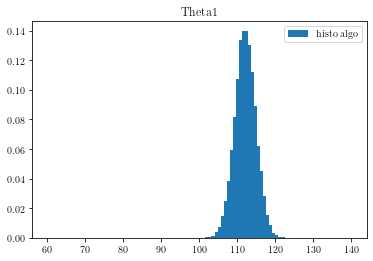

In [45]:
# Bending angle Theta1
pyplot.hist(theta1Vec*180/np.pi,bins=100,density=True,label='histo algo',range=(60,140))
pyplot.title('Theta1')
pyplot.legend()
plt.show()
#plt.savefig('Theta1')

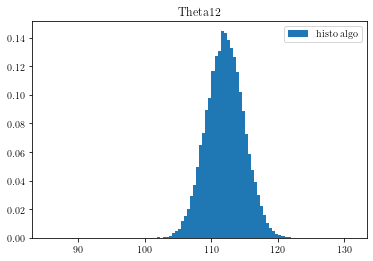

In [46]:
# Bending angle Theta12
pyplot.hist(theta12Vec*180/np.pi,bins=100,density=True,label='histo algo')
pyplot.title('Theta12')
pyplot.legend()
plt.show()
#plt.savefig('Theta12')

Number of iterations:  0
Number of iterations:  100000
Number of iterations:  200000
Number of iterations:  300000
Number of iterations:  400000
Number of iterations:  500000
Number of iterations:  600000
Number of iterations:  700000
Number of iterations:  800000
Number of iterations:  900000


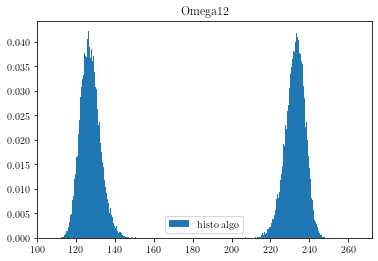

In [47]:
# Dihedral angle omega12
omega12Vec= np.zeros(len(theta12Vec))

for i in range(len(theta12Vec)):
    cosomega12 = (np.cos(theta12Vec[i])-np.cos(theta1Vec[i])*np.cos(theta2Vec[i]))/(np.sin(theta1Vec[i])*np.sin(theta2Vec[i]))
    rnd = np.random.rand(1)
    if rnd < 1/2:
        omega12Vec[i] = np.arccos(cosomega12)
    else:
        omega12Vec[i] = 2*np.pi-np.arccos(cosomega12)
    if(np.mod(i*10,len(theta12Vec))==0):
        print('Number of iterations: ',i)
        
pyplot.hist(omega12Vec*180/np.pi,bins=500,density=True,label='histo algo')
pyplot.title('Omega12')
pyplot.legend()
plt.show()
#plt.savefig('Omega12_2-methylpropane_theta0=112')


### 2.3 Sampling the prior distributions <a name="PriorSampling"></a>

In [48]:
# Sampling the prior distribution with sample_prior()

niter = 0
Maxiter = 20000

numberofangles = np.int((nbranches+1)*nbranches/2)

ThetaMatInit = np.zeros((numberofangles,Maxiter)) 



while niter < Maxiter:
    x = sample_prior(nbranches)
    ind = 0
    for i in range(nbranches+1):
        for j in range(i+1,nbranches+1):
            ThetaMatInit[ind, niter]=np.arccos(np.dot(x[i],x[j]))
            ind += 1 
    
    niter = niter+1
    
    if(np.mod(niter*10,Maxiter)==0):
        print('Number of iterations: ',niter)

if nbranches == 2:
    theta1VecInit = ThetaMatInit[0]
    theta2VecInit = ThetaMatInit[1]
    theta12VecInit = ThetaMatInit[2]
    
if nbranches == 3:
    theta1VecInit = ThetaMatInit[0]
    theta2VecInit = ThetaMatInit[1]
    theta3VecInit = ThetaMatInit[2]
    theta12VecInit = ThetaMatInit[3]
    theta13VecInit = ThetaMatInit[4]
    theta23VecInit = ThetaMatInit[5]
    
print('--------------------------')

Number of iterations:  2000
Number of iterations:  4000
Number of iterations:  6000
Number of iterations:  8000
Number of iterations:  10000
Number of iterations:  12000
Number of iterations:  14000
Number of iterations:  16000
Number of iterations:  18000
Number of iterations:  20000
--------------------------


In [49]:
# prior distribution - analytical
dx=0.0001*180/np.pi
x=90
xVecT=np.array([])
yVecT=np.array([])
nm=0.
while(x<135):
    py=Ptheta(x*np.pi/180)
    nm=nm+dx*py
    xVecT=np.append(xVecT,x)
    yVecT=np.append(yVecT,py)
    x=x+dx
yVecT=yVecT/nm

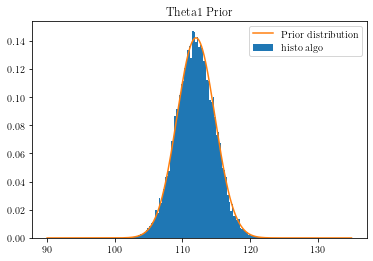

In [50]:
pyplot.hist(theta1VecInit*180/np.pi,bins=100,density=True,label='histo algo')
pyplot.plot(xVecT,yVecT,label='Prior distribution')
pyplot.title('Theta1 Prior')
pyplot.legend()
plt.show()
#plt.savefig('Theta1_2_methylpropane_theta0=112')


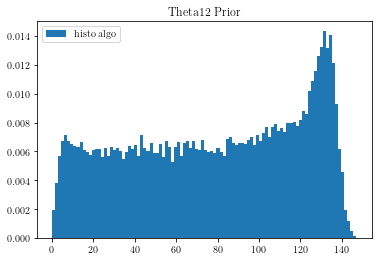

In [51]:
pyplot.hist(theta12VecInit*180/np.pi,bins=100,density=True,label='histo algo')
pyplot.title('Theta12 Prior')
pyplot.legend()
plt.show()
#plt.savefig('plots/Theta12_prior')


### 2.4 Asymptotic Results <a name="Asymptotic"></a>

Number of iterations:  0 Acceptance rate: 1.0
Number of iterations:  40000 Acceptance rate: 0.8411789705257369
Number of iterations:  80000 Acceptance rate: 0.8409019887251409
Number of iterations:  120000 Acceptance rate: 0.8420596495029208
Number of iterations:  160000 Acceptance rate: 0.8418134886656958


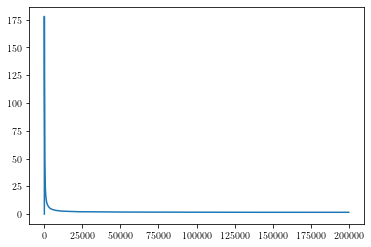

Number of iterations:  200000 Acceptance rate: 0.8417807910960445
Number of iterations:  240000 Acceptance rate: 0.8407548301882075
Number of iterations:  280000 Acceptance rate: 0.8412577097938936
Number of iterations:  320000 Acceptance rate: 0.8407442476742261
Number of iterations:  360000 Acceptance rate: 0.8405448873753129


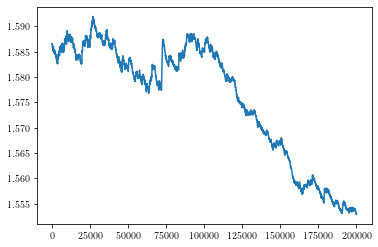

Number of iterations:  400000 Acceptance rate: 0.8405128987177533
Number of iterations:  440000 Acceptance rate: 0.8400980906861575
Number of iterations:  480000 Acceptance rate: 0.8400128333065973
Number of iterations:  520000 Acceptance rate: 0.8399753077397928
Number of iterations:  560000 Acceptance rate: 0.839791357515433


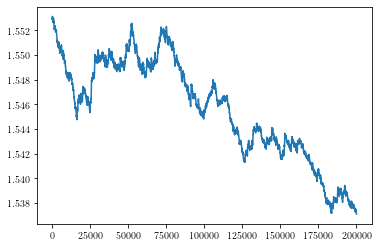

Number of iterations:  600000 Acceptance rate: 0.8397119338134437
Number of iterations:  640000 Acceptance rate: 0.8397080629561516
Number of iterations:  680000 Acceptance rate: 0.8398693531333042
Number of iterations:  720000 Acceptance rate: 0.8398280002388886
Number of iterations:  760000 Acceptance rate: 0.8395791584484757


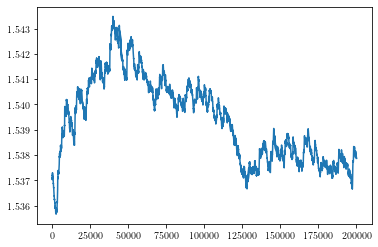

Number of iterations:  800000 Acceptance rate: 0.8394602006747491
Number of iterations:  840000 Acceptance rate: 0.8394716196766432
Number of iterations:  880000 Acceptance rate: 0.8395024551108464
Number of iterations:  920000 Acceptance rate: 0.8396762612214552
Number of iterations:  960000 Acceptance rate: 0.839660583686892


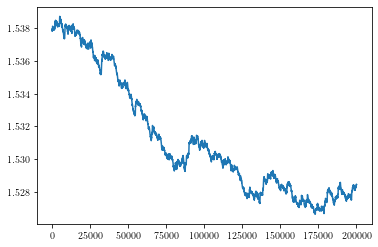

Number of iterations:  1000000 Acceptance rate: 0.8396661603338397
Number of iterations:  1040000 Acceptance rate: 0.8396818849212645
Number of iterations:  1080000 Acceptance rate: 0.8396908891751026
Number of iterations:  1120000 Acceptance rate: 0.8397501430802294
Number of iterations:  1160000 Acceptance rate: 0.8396441037550829


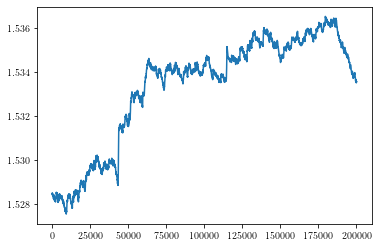

Number of iterations:  1200000 Acceptance rate: 0.8396443002964165
Number of iterations:  1240000 Acceptance rate: 0.8397404518222162
Number of iterations:  1280000 Acceptance rate: 0.8398118438969969
Number of iterations:  1320000 Acceptance rate: 0.8397258789955462
Number of iterations:  1360000 Acceptance rate: 0.8397971766197231


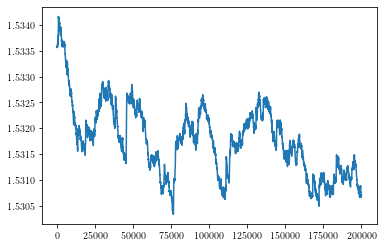

Number of iterations:  1400000 Acceptance rate: 0.8397265430524693
Number of iterations:  1440000 Acceptance rate: 0.839714000198611
Number of iterations:  1480000 Acceptance rate: 0.8397095677638056
Number of iterations:  1520000 Acceptance rate: 0.8396908949402007
Number of iterations:  1560000 Acceptance rate: 0.8396795899489808


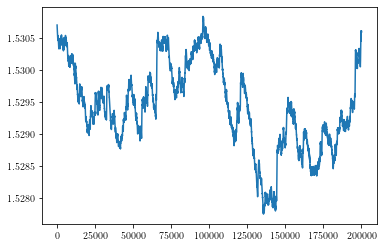

Number of iterations:  1600000 Acceptance rate: 0.8396319752300154
Number of iterations:  1640000 Acceptance rate: 0.839608634384979
Number of iterations:  1680000 Acceptance rate: 0.8396316430764029
Number of iterations:  1720000 Acceptance rate: 0.8396745118171443
Number of iterations:  1760000 Acceptance rate: 0.83975065923258


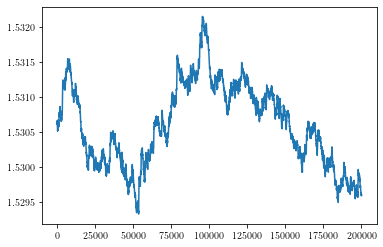

Number of iterations:  1800000 Acceptance rate: 0.8397634223536542
Number of iterations:  1840000 Acceptance rate: 0.8398169348821006
Number of iterations:  1880000 Acceptance rate: 0.8399282766338954
Number of iterations:  1920000 Acceptance rate: 0.8399839375083659
Number of iterations:  1960000 Acceptance rate: 0.8400577346644211


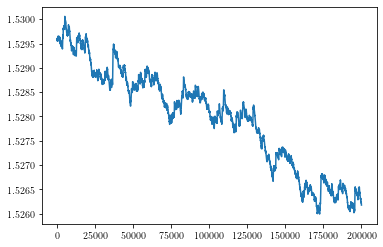

Final acceptance rate: 0.840102


In [109]:
NMC=2000000
iMC=0
StartSampling=1000000 #First iteration with the angles recorded
accrate=0
dangleMax=3.0*np.pi/180

xVecE = np.arange(np.int(NMC/10)+1)

numberofangles = np.int((nbranches+1)*nbranches/2)


#EnergyVec = np.array([])
MeanEnergyVec = np.array([0])

ThetaMatAS = np.zeros((numberofangles,NMC-StartSampling-1)) 

    
# Generate the sample configuration and compute the prior probability
x=sample_prior(nbranches)
Pold=Ptarg(x)
    
iMC=0

while(iMC<NMC):
    rotindex = np.random.randint(0,3)
    rotaxis = random_unit_vector() 
    Dangle = dangleMax*(2*np.random.rand()-1.)
    y=rotation(deepcopy(x),rotindex,Dangle,rotaxis)
    Pnew = Ptarg(y)



# Metropolis
    accxy=Pnew/Pold

    # Implement Heat Bath
#    accxy=Pnew/(Pnew+Pold)

#    accxx=1.-accxy
        
    rnd=np.random.rand(1)
    if(rnd[0]<accxy):
        x=deepcopy(y)
        Pold = Pnew
        accrate=accrate+1
        
#    EnergyVec = np.append(EnergyVec, Energy(x))

    MeanEnergyVec = np.append(MeanEnergyVec, (MeanEnergyVec[-1]*iMC +Energy(x))  / (iMC+1) )

    
    
    if iMC > StartSampling:
        ind = 0
        for i in range(nbranches+1):
            for j in range(i+1,nbranches+1):
                ThetaMatAS[ind, iMC-StartSampling-1]=np.arccos(np.dot(x[i],x[j]))
                ind += 1 

    if(np.mod(iMC*50,NMC)==0):
        print('Number of iterations: ',iMC, 'Acceptance rate:',accrate/(iMC+1))
        
    iMC=iMC+1
    
    if(np.mod(iMC*10,NMC)==0):
        pyplot.plot(xVecE,MeanEnergyVec)
        plt.show()
#        EnergyVec = np.array([])
        MeanEnergyVec = np.array([MeanEnergyVec[-1]])

if nbranches == 2:
    ThetaMatAS2 = ThetaMatAS
    theta1VecAS = ThetaMatAS[0]
    theta2VecAS = ThetaMatAS[1]
    theta12VecAS = ThetaMatAS[2]
    
if nbranches == 3:
    ThetaMatAS3 = ThetaMatAS
    theta1VecAS = ThetaMatAS[0]
    theta2VecAS = ThetaMatAS[1]
    theta3VecAS = ThetaMatAS[2]
    theta12VecAS = ThetaMatAS[3]
    theta13VecAS = ThetaMatAS[4]
    theta23VecAS = ThetaMatAS[5]        
        
print('Final acceptance rate:',accrate/(NMC))

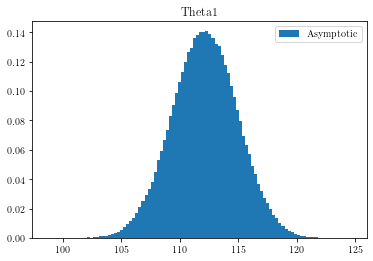

In [54]:
# Bending angle Theta1 asymptotic
DensityTheta1 = stats.gaussian_kde(theta1VecAS*180/np.pi)
pyplot.hist(theta1VecAS*180/np.pi,bins=100,density=True,label='Asymptotic')
pyplot.title('Theta1')
plt.legend()
plt.show()

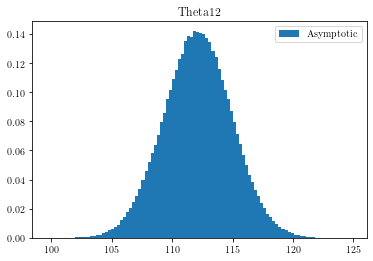

In [55]:
# Bending angle Theta12 asymptotic
DensityTheta12 = stats.gaussian_kde(theta12VecAS*180/np.pi)
pyplot.hist(theta12VecAS*180/np.pi,bins=100,density=True,label='Asymptotic')
pyplot.title('Theta12')
pyplot.legend()
plt.show()

Number of iterations:  0


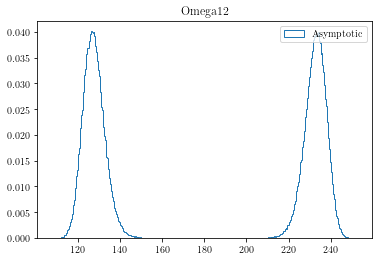

In [56]:
# Dihedral angle Omega_12 asymptotic
omega12VecAS= np.zeros(len(theta12VecAS))

for i in range(len(theta12VecAS)):
    cosomega12AS = (np.cos(theta12VecAS[i])-np.cos(theta1VecAS[i])*np.cos(theta2VecAS[i]))/(np.sin(theta1VecAS[i])*np.sin(theta2VecAS[i]))
    rnd = np.random.rand(1)
    if rnd < 1/2:
        omega12VecAS[i] = np.arccos(cosomega12AS)
    else:
        omega12VecAS[i] = 2*np.pi-np.arccos(cosomega12AS)
    if(np.mod(i*10,len(theta12VecAS)+1)==0):
        print('Number of iterations: ',i)
    
pyplot.hist(omega12VecAS*180/np.pi,bins=500,density=True,histtype='step',label='Asymptotic')
pyplot.title('Omega12')
pyplot.legend()
plt.show()

In [110]:
# Save the asymptotic sampling
if nbranches == 2:
    np.save('data/BM2_ThetaMatAS', ThetaMatAS2)
if nbranches == 3:
    np.save('data/BM3_ThetaMatAS', ThetaMatAS3)

### Checking the symmetry

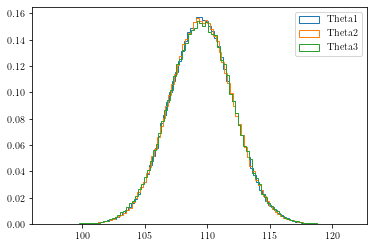

In [76]:
pyplot.hist(theta1VecAS*180/np.pi,bins=100,density=True,histtype='step',label='Theta1')
pyplot.hist(theta2VecAS*180/np.pi,bins=100,density=True,histtype='step',label='Theta2')
pyplot.hist(theta3VecAS*180/np.pi,bins=100,density=True,histtype='step',label='Theta3')
pyplot.legend()
plt.show()

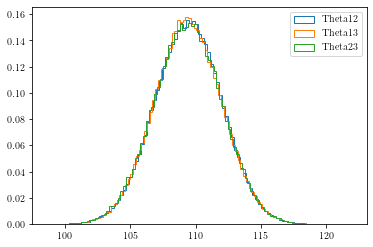

In [79]:
pyplot.hist(theta12VecAS*180/np.pi,bins=100,density=True,histtype='step',label='Theta12')
pyplot.hist(theta13VecAS*180/np.pi,bins=100,density=True,histtype='step',label='Theta13')
pyplot.hist(theta23VecAS*180/np.pi,bins=100,density=True,histtype='step',label='Theta23')
pyplot.legend()
plt.show()

### 2.5 Comparison TMCMC and Asymptotic  <a name="CompTMCMCAS"></a>

Load sampling and asymptotic sampling

In [4]:
if nbranches == 2:
    ThetaMatAS = np.load('data/BM2_ThetaMatAS.npy')
    ThetaMat = np.load('data/BM2_AlgoA_NMC=1e+06_dxMax=1.5708_n=4_ThetaMat.npy')
    theta1VecAS = ThetaMatAS[0]
    theta2VecAS = ThetaMatAS[1]
    theta12VecAS = ThetaMatAS[2]
    theta1Vec = ThetaMat[0]
    theta2Vec = ThetaMat[1]
    theta12Vec = ThetaMat[2]
    
if nbranches == 3:
    ThetaMatAS = np.load('data/BM3_ThetaMatAS.npy')
    ThetaMat = np.load('data/BM3_AlgoA_NMC=1e+06_dxMax=1.5708_n=4_ThetaMat.npy')
    theta1VecAS = ThetaMatAS[0]
    theta2VecAS = ThetaMatAS[1]
    theta3VecAS = ThetaMatAS[2]
    theta12VecAS = ThetaMatAS[3]
    theta13VecAS = ThetaMatAS[4]
    theta23VecAS = ThetaMatAS[5]
    theta1Vec = ThetaMat[0]
    theta2Vec = ThetaMat[1]
    theta3Vec = ThetaMat[2]
    theta12Vec = ThetaMat[3]
    theta13Vec = ThetaMat[4]
    theta23Vec = ThetaMat[5]

Compare the samplings with the asymptotic distribution

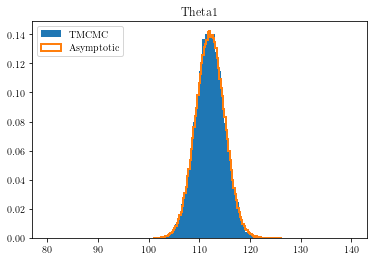

In [5]:
pyplot.hist(theta1Vec*180/np.pi,bins=100,density=True,label='TMCMC',range=(80,140))
pyplot.hist(theta1VecAS*180/np.pi,bins=100,density=True,histtype='step',linewidth=2,label='Asymptotic')
pyplot.title('Theta1')
plt.legend()
plt.show()

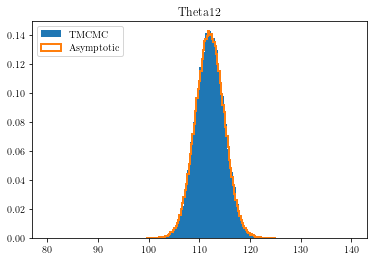

In [6]:
pyplot.hist(theta12Vec*180/np.pi,bins=100,density=True,label='TMCMC', range=(80,140))
pyplot.hist(theta12VecAS*180/np.pi,bins=100,density=True,histtype='step',linewidth=2,label='Asymptotic')
pyplot.title('Theta12')
plt.legend()
plt.show()

## 3. Figures <a name="Figures"></a>

### 3.1 Figure 4 <a name="Fig4"></a>

In [8]:
# Asymptotic distribution
thetaMatAS = np.load('data/BM2_ThetaMatAS.npy')
theta1VecAS = ThetaMatAS[0]
theta2VecAS = ThetaMatAS[1]
theta12VecAS = ThetaMatAS[2]

omega12VecAS= np.zeros(len(theta12VecAS))

for i in range(len(theta12VecAS)):
    cosomega12AS = (np.cos(theta12VecAS[i])-np.cos(theta1VecAS[i])*np.cos(theta2VecAS[i]))/(np.sin(theta1VecAS[i])*np.sin(theta2VecAS[i]))
    rnd = np.random.rand(1)
    if rnd < 1/2:
        omega12VecAS[i] = np.arccos(cosomega12AS)
    else:
        omega12VecAS[i] = 2*np.pi-np.arccos(cosomega12AS)
    if(np.mod(i*10,len(theta12VecAS)+1)==0):
        print('Number of iterations: ',i)

Number of iterations:  0
Number of iterations:  100000
Number of iterations:  200000
Number of iterations:  300000
Number of iterations:  400000
Number of iterations:  500000
Number of iterations:  600000
Number of iterations:  700000
Number of iterations:  800000
Number of iterations:  900000


In [9]:
ThetaMatA = np.load('data/BM2_AlgoA_NMC=1e+06_dxMax=1.5708_n=4_ThetaMat.npy')

theta1VecA = ThetaMatA[0]
theta2VecA = ThetaMatA[1]
theta12VecA = ThetaMatA[2]

omega12VecA= np.zeros(len(theta12VecA))

for i in range(len(theta12VecA)):
    cosomega12A = (np.cos(theta12VecA[i])-np.cos(theta1VecA[i])*np.cos(theta2VecA[i]))/(np.sin(theta1VecA[i])*np.sin(theta2VecA[i]))
    rnd = np.random.rand(1)
    if rnd < 1/2:
        omega12VecA[i] = np.arccos(cosomega12A)
    else:
        omega12VecA[i] = 2*np.pi-np.arccos(cosomega12A)
    if(np.mod(i*10,len(theta12VecA))==0):
        print('Number of iterations: ',i)
        

Number of iterations:  0
Number of iterations:  100000
Number of iterations:  200000
Number of iterations:  300000
Number of iterations:  400000
Number of iterations:  500000
Number of iterations:  600000
Number of iterations:  700000
Number of iterations:  800000
Number of iterations:  900000


In [10]:
ThetaMatB = np.load('data/BM2_AlgoB_NMC=1e+06_dxMax=1.5708_n=4_ThetaMat.npy')


theta1VecB = ThetaMatB[0]
theta2VecB = ThetaMatB[1]
theta12VecB = ThetaMatB[2]

omega12VecB = np.zeros(len(theta12VecB))

for i in range(len(theta12VecB)):
    cosomega12B = (np.cos(theta12VecB[i])-np.cos(theta1VecB[i])*np.cos(theta2VecB[i]))/(np.sin(theta1VecB[i])*np.sin(theta2VecB[i]))
    rnd = np.random.rand(1)
    if rnd < 1/2:
        omega12VecB[i] = np.arccos(cosomega12B)
    else:
        omega12VecB[i] = 2*np.pi-np.arccos(cosomega12B)
    if(np.mod(i*10,len(theta12VecB))==0):
        print('Number of iterations: ',i)
        

Number of iterations:  0
Number of iterations:  100000
Number of iterations:  200000
Number of iterations:  300000
Number of iterations:  400000
Number of iterations:  500000
Number of iterations:  600000
Number of iterations:  700000
Number of iterations:  800000
Number of iterations:  900000


In [11]:
ThetaMatnew4 = np.load('data/BM2_AlgoA_NMC=1e+06_dxMax=1.5708_n=4_ThetaMatnew.npy')

theta1Vecnew4 = ThetaMatnew4[0]
theta2Vecnew4 = ThetaMatnew4[1]
theta12Vecnew4 = ThetaMatnew4[2]

omega12Vecnew4= np.zeros(len(theta12Vecnew4))

for i in range(len(theta12Vecnew4)):
    cosomega12new4 = (np.cos(theta12Vecnew4[i])-np.cos(theta1Vecnew4[i])*np.cos(theta2Vecnew4[i]))/(np.sin(theta1Vecnew4[i])*np.sin(theta2Vecnew4[i]))
    rnd = np.random.rand(1)
    if rnd < 1/2:
        omega12Vecnew4[i] = np.arccos(cosomega12new4)
    else:
        omega12Vecnew4[i] = 2*np.pi-np.arccos(cosomega12new4)
    if(np.mod(i*10,len(theta12Vecnew4))==0):
        print('Number of iterations: ',i)
        

Number of iterations:  0
Number of iterations:  100000
Number of iterations:  200000
Number of iterations:  300000
Number of iterations:  400000
Number of iterations:  500000
Number of iterations:  600000
Number of iterations:  700000
Number of iterations:  800000
Number of iterations:  900000


In [12]:
ThetaMatnew10 = np.load('data/BM2_AlgoA_NMC=1e+06_dxMax=1.5708_n=10_ThetaMatnew.npy')

theta1Vecnew10 = ThetaMatnew10[0]
theta2Vecnew10 = ThetaMatnew10[1]
theta12Vecnew10 = ThetaMatnew10[2]

omega12Vecnew10 = np.zeros(len(theta12Vecnew10))

for i in range(len(theta12Vecnew10)):
    cosomega12new10 = (np.cos(theta12Vecnew10[i])-np.cos(theta1Vecnew10[i])*np.cos(theta2Vecnew10[i]))/(np.sin(theta1Vecnew10[i])*np.sin(theta2Vecnew10[i]))
    rnd = np.random.rand(1)
    if rnd < 1/2:
        omega12Vecnew10[i] = np.arccos(cosomega12new10)
    else:
        omega12Vecnew10[i] = 2*np.pi-np.arccos(cosomega12new10)
    if(np.mod(i*10,len(theta12Vecnew10))==0):
        print('Number of iterations: ',i)
  

Number of iterations:  0
Number of iterations:  100000
Number of iterations:  200000
Number of iterations:  300000
Number of iterations:  400000
Number of iterations:  500000
Number of iterations:  600000
Number of iterations:  700000
Number of iterations:  800000
Number of iterations:  900000


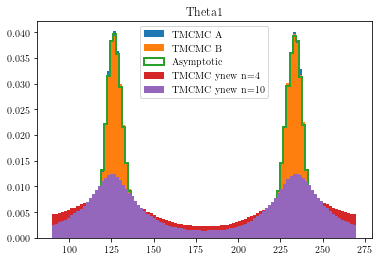

In [13]:
omega12VecAdist, binsomega, patches = pyplot.hist(omega12VecA*180/np.pi,bins=100,density=True,label='TMCMC A',range=(90,270))
omega12VecBdist, binsomegaB, patches = pyplot.hist(omega12VecB*180/np.pi,bins=100,density=True,label='TMCMC B',range=(90,270))
omega12VecASdist, binsAS, patches = pyplot.hist(omega12VecAS*180/np.pi,bins=100,density=True,histtype='step',linewidth=2,label='Asymptotic',range=(90,270))
omega12Vecnew4dist, binsomega4, patches = pyplot.hist(omega12Vecnew4*180/np.pi,bins=100,density=True,label='TMCMC ynew n=4',range=(90,270))
omega12Vecnew10dist, binsomega10, patches = pyplot.hist(omega12Vecnew10*180/np.pi,bins=100,density=True,label='TMCMC ynew n=10',range=(90,270))
pyplot.title('Theta1')
plt.legend()

newbinsomega= binsomega - (binsomega[1]-binsomega[0])/2
newbinsomega=newbinsomega[1:]


plt.show()

In [14]:
# Asymptotic distribution
thetaMatAS3 = np.load('data/BM3_ThetaMatAS.npy')
theta1VecAS3 = thetaMatAS3[0]
theta2VecAS3 = thetaMatAS3[1]
theta12VecAS3 = thetaMatAS3[3]

omega12VecAS3= np.zeros(len(theta12VecAS3))

for i in range(len(theta12VecAS3)):
    cosomega12AS3 = (np.cos(theta12VecAS3[i])-np.cos(theta1VecAS3[i])*np.cos(theta2VecAS3[i]))/(np.sin(theta1VecAS3[i])*np.sin(theta2VecAS3[i]))
    rnd = np.random.rand(1)
    if rnd < 1/2:
        omega12VecAS3[i] = np.arccos(cosomega12AS3)
    else:
        omega12VecAS3[i] = 2*np.pi-np.arccos(cosomega12AS3)
    if(np.mod(i*10,len(theta12VecAS3)+1)==0):
        print('Number of iterations: ',i)

Number of iterations:  0
Number of iterations:  100000
Number of iterations:  200000
Number of iterations:  300000
Number of iterations:  400000
Number of iterations:  500000
Number of iterations:  600000
Number of iterations:  700000
Number of iterations:  800000
Number of iterations:  900000


In [15]:
ThetaMatA3 = np.load('data/BM3_AlgoA_NMC=1e+06_dxMax=1.5708_n=4_ThetaMat.npy')

theta1VecA3 = ThetaMatA3[0]
theta2VecA3 = ThetaMatA3[1]
theta12VecA3 = ThetaMatA3[3]

omega12VecA3= np.zeros(len(theta12VecA3))

for i in range(len(theta12VecA3)):
    cosomega12A3 = (np.cos(theta12VecA3[i])-np.cos(theta1VecA3[i])*np.cos(theta2VecA3[i]))/(np.sin(theta1VecA3[i])*np.sin(theta2VecA3[i]))
    rnd = np.random.rand(1)
    if rnd < 1/2:
        omega12VecA3[i] = np.arccos(cosomega12A3)
    else:
        omega12VecA3[i] = 2*np.pi-np.arccos(cosomega12A3)
    if(np.mod(i*10,len(theta12VecA3))==0):
        print('Number of iterations: ',i)
        

Number of iterations:  0
Number of iterations:  100000
Number of iterations:  200000
Number of iterations:  300000
Number of iterations:  400000
Number of iterations:  500000
Number of iterations:  600000
Number of iterations:  700000
Number of iterations:  800000
Number of iterations:  900000


In [16]:
ThetaMatB3 = np.load('data/BM3_AlgoB_NMC=1e+06_dxMax=1.5708_n=4_ThetaMat.npy')

theta1VecB3 = ThetaMatB3[0]
theta2VecB3 = ThetaMatB3[1]
theta12VecB3 = ThetaMatB3[2]

omega12VecB3 = np.zeros(len(theta12VecB3))

for i in range(len(theta12VecB3)):
    cosomega12B3 = (np.cos(theta12VecB3[i])-np.cos(theta1VecB3[i])*np.cos(theta2VecB3[i]))/(np.sin(theta1VecB3[i])*np.sin(theta2VecB3[i]))
    rnd = np.random.rand(1)
    if rnd < 1/2:
        omega12VecB3[i] = np.arccos(cosomega12B3)
    else:
        omega12VecB3[i] = 2*np.pi-np.arccos(cosomega12B3)
    if(np.mod(i*10,len(theta12VecB3))==0):
        print('Number of iterations: ',i)
        

Number of iterations:  0
Number of iterations:  100000
Number of iterations:  200000
Number of iterations:  300000
Number of iterations:  400000
Number of iterations:  500000
Number of iterations:  600000
Number of iterations:  700000
Number of iterations:  800000
Number of iterations:  900000


In [17]:
ThetaMatnew43 = np.load('data/BM3_AlgoA_NMC=1e+06_dxMax=1.5708_n=4_ThetaMatnew.npy')

theta1Vecnew43 = ThetaMatnew43[0]
theta2Vecnew43 = ThetaMatnew43[1]
theta12Vecnew43 = ThetaMatnew43[3]

omega12Vecnew43= np.zeros(len(theta12Vecnew43))

for i in range(len(theta12Vecnew43)):
    cosomega12new43 = (np.cos(theta12Vecnew43[i])-np.cos(theta1Vecnew43[i])*np.cos(theta2Vecnew43[i]))/(np.sin(theta1Vecnew43[i])*np.sin(theta2Vecnew43[i]))
    rnd = np.random.rand(1)
    if rnd < 1/2:
        omega12Vecnew43[i] = np.arccos(cosomega12new43)
    else:
        omega12Vecnew43[i] = 2*np.pi-np.arccos(cosomega12new43)
    if(np.mod(i*10,len(theta12Vecnew43))==0):
        print('Number of iterations: ',i)
        

Number of iterations:  0
Number of iterations:  100000
Number of iterations:  200000
Number of iterations:  300000
Number of iterations:  400000
Number of iterations:  500000
Number of iterations:  600000
Number of iterations:  700000
Number of iterations:  800000
Number of iterations:  900000


In [18]:
ThetaMatnew103 = np.load('data/BM3_AlgoA_NMC=1e+06_dxMax=1.5708_n=10_ThetaMatnew.npy')

theta1Vecnew103 = ThetaMatnew103[0]
theta2Vecnew103 = ThetaMatnew103[1]
theta12Vecnew103 = ThetaMatnew103[3]

omega12Vecnew103= np.zeros(len(theta12Vecnew103))

for i in range(len(theta12Vecnew103)):
    cosomega12new103 = (np.cos(theta12Vecnew103[i])-np.cos(theta1Vecnew103[i])*np.cos(theta2Vecnew103[i]))/(np.sin(theta1Vecnew103[i])*np.sin(theta2Vecnew103[i]))
    rnd = np.random.rand(1)
    if rnd < 1/2:
        omega12Vecnew103[i] = np.arccos(cosomega12new103)
    else:
        omega12Vecnew103[i] = 2*np.pi-np.arccos(cosomega12new103)
    if(np.mod(i*10,len(theta12Vecnew103))==0):
        print('Number of iterations: ',i)
       

Number of iterations:  0
Number of iterations:  100000
Number of iterations:  200000
Number of iterations:  300000
Number of iterations:  400000
Number of iterations:  500000
Number of iterations:  600000
Number of iterations:  700000
Number of iterations:  800000
Number of iterations:  900000


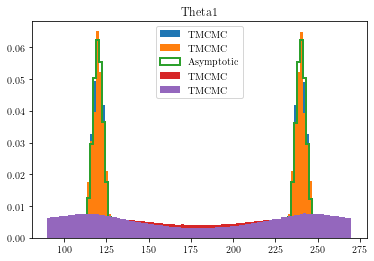

In [19]:
omega12VecA3dist, binsomega, patches = pyplot.hist(omega12VecA3*180/np.pi,bins=100,density=True,label='TMCMC',range=(90,270))
omega12VecB3dist, binsomegaB, patches = pyplot.hist(omega12VecB3*180/np.pi,bins=100,density=True,label='TMCMC',range=(90,270))
omega12VecAS3dist, binsAS, patches = pyplot.hist(omega12VecAS3*180/np.pi,bins=100,density=True,histtype='step',linewidth=2,label='Asymptotic',range=(90,270))
omega12Vecnew43dist, binsomega4, patches = pyplot.hist(omega12Vecnew43*180/np.pi,bins=100,density=True,label='TMCMC',range=(90,270))
omega12Vecnew103dist, binsomega10, patches = pyplot.hist(omega12Vecnew103*180/np.pi,bins=100,density=True,label='TMCMC',range=(90,270))


pyplot.title('Theta1')
plt.legend()

newbinsomega3= binsomega - (binsomega[1]-binsomega[0])/2
newbinsomega3=newbinsomega3[1:]


plt.show()
#plt.savefig('plots/Theta1_2_methylpropane_theta0=112')

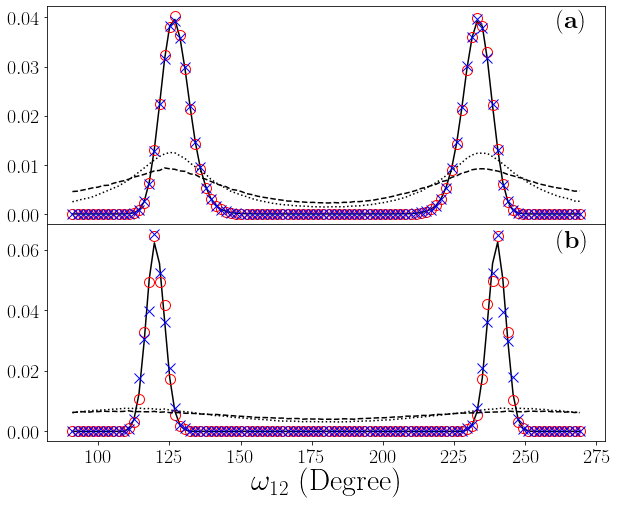

In [20]:
#fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(8, 12))
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])
BM2 = mpimg.imread('plots/Figures/FigBM2.jpg')
BM3 = mpimg.imread('plots/Figures/FigBM3.jpg')

ax1 = plt.subplot(gs[0])
ax1.plot(newbinsomega,omega12VecASdist,color='k',label=r'Asymptotic')
ax1.plot(newbinsomega,omega12VecAdist,'o',color='r',fillstyle='none',markersize=10,label=r'Algorithm A')
ax1.plot(newbinsomega,omega12VecBdist,'x',color='b',markersize=10,label=r'Algorithm B')
ax1.plot(newbinsomega,omega12Vecnew4dist,'--',color='k',label=r'$\omega_{12,new}^{n=4}$')
ax1.plot(newbinsomega,omega12Vecnew10dist,':',color='k',label=r'$\omega_{12,new}^{n=10}$')
ax1.set_xlabel(r'$\omega_{12}$ (Degree)',fontsize=30)
#plt.title(r'Dihedral angle of 2-methylpropane',fontsize=20)
#ax1.legend(fontsize=20)
ax1.text(261, 0.038, r'$(\mathrm{\bf a})$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(gs[1], sharex = ax1)
ax2.plot(newbinsomega3,omega12VecAS3dist,color='k',label=r'Asymptotic')
ax2.plot(newbinsomega3,omega12VecA3dist,'o',color='r',fillstyle='none',markersize=10,label=r'Algorithm A')
ax2.plot(newbinsomega3,omega12VecB3dist,'x',color='b',markersize=10,label=r'Algorithm B')
ax2.plot(newbinsomega3,omega12Vecnew43dist,'--',color='k',label=r'$\omega_{12,new}^{n=4}$')
ax2.plot(newbinsomega3,omega12Vecnew103dist,':',color='k',label=r'$\omega_{12,new}^{n=10}$')
ax2.set_xlabel(r'$\omega_{12}$ (Degree)',fontsize=30)
#plt.title(r'Dihedral angle of  2,2-dimethylpropane',fontsize=20)
#ax2.legend(fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=20)
yticks = ax2.yaxis.get_major_ticks()
yticks[-1].label2.set_visible(False)
ax2.text(261, 0.061, r'$(\mathrm{\bf b})$', fontsize=25)

#newax = fig.add_axes([0.33, 0.57, 0.3, 0.3], anchor='NE', zorder=1)
#newax.imshow(BM2)
#newax.axis('off')

#newax = fig.add_axes([0.33, 0.2, 0.3, 0.3], anchor='NE', zorder=1)
#newax.imshow(BM3)
#newax.axis('off')


plt.subplots_adjust(hspace=.0)

plt.show()

### 3.2 Figure P_gen BM2 <a name="FigPgenBM2"></a>

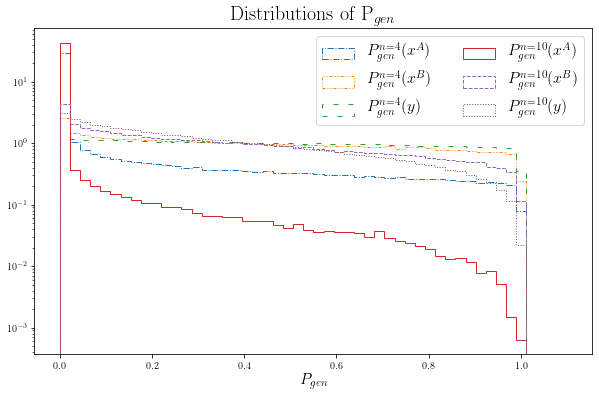

In [21]:
alphaA_zstatsn4 = np.load('data/BM2_AlgoA_NMC=1e+06_dxMax=1.5708_n=4_zstats.npy')
alphaB_zstatsn4 = np.load('data/BM2_AlgoB_NMC=1e+06_dxMax=1.5708_n=4_zstats.npy')
alphaA_zstatsn10 = np.load('data/BM2_AlgoA_NMC=1e+06_dxMax=1.5708_n=10_zstats.npy')
alphaB_zstatsn10 = np.load('data/BM2_AlgoB_NMC=100000_dxMax=1.5708_n=10_zstats.npy')

proboldVecAn4 = alphaA_zstatsn4[0]
probnewVecAn4 = alphaA_zstatsn4[1]
PtargoldVecAn4 = alphaA_zstatsn4[2]
PtargnewVecAn4 = alphaA_zstatsn4[3]

zAn4 = PtargnewVecAn4/PtargnewVecAn4 * proboldVecAn4 / probnewVecAn4

proboldVecBn4 = alphaB_zstatsn4[0]
probnewVecBn4 = alphaB_zstatsn4[1]
PtargoldVecAn4  = alphaB_zstatsn4[2]
PtargnewVecBn4 = alphaB_zstatsn4[3]
PgennewVecBn4 = alphaB_zstatsn4[4]

zBn4 = PtargnewVecBn4/PtargnewVecBn4 * proboldVecBn4 / probnewVecBn4

proboldVecAn10 = alphaA_zstatsn10[0]
probnewVecAn10 = alphaA_zstatsn10[1]
PtargoldVecAn10 = alphaA_zstatsn10[2]
PtargnewVecAn10 = alphaA_zstatsn10[3]

zAn10 = PtargnewVecAn10/PtargnewVecAn10 * proboldVecAn10 / probnewVecAn10

proboldVecBn10 = alphaB_zstatsn10[0]
probnewVecBn10 = alphaB_zstatsn10[1]
PtargoldVecAn10  = alphaB_zstatsn10[2]
PtargnewVecBn10 = alphaB_zstatsn10[3]
PgennewVecBn10 = alphaB_zstatsn10[4]

zBn10 = PtargnewVecBn10/PtargnewVecBn10 * proboldVecBn10 / probnewVecBn10

for i in range(len(zAn4)):
    if zAn4[i]>1:
        zAn4[i]=1

for i in range(len(zBn4)):
    if zBn4[i]>1:
        zBn4[i]=1

for i in range(len(zAn10)):
    if zAn10[i]>1:
        zAn10[i]=1

for i in range(len(zBn10)):
    if zBn10[i]>1:
        zBn10[i]=1
        
fig = plt.figure(figsize=(10, 6))
proboldVecAn4dist, bins, patches = pyplot.hist(proboldVecAn4,bins=50,density=True,label=r'$P^{n=4}_{gen}(x^A)$',histtype='step',linestyle=('dashdot'),range=(0,1.1))
PgennewVecBn4dist, bins, patches = pyplot.hist(PgennewVecBn4,bins=50,density=True,label=r'$P^{n=4}_{gen}(x^B)$',histtype='step',linestyle=((0, (3, 2, 1, 2, 1,2))),range=(0,1.1))
probnewVecAn4dist, bins, patches = pyplot.hist(probnewVecAn4,bins=50,density=True,label=r'$P^{n=4}_{gen}(y)$',histtype='step',linestyle=((0, (5, 10))),range=(0,1.1))
#pyplot.hist(zAn4,bins=100,density=True,label=r'$z_A^{n=4}$',histtype='step')
proboldVecAn10dist, bins, patches = pyplot.hist(proboldVecAn10,bins=50,density=True,label=r'$P^{n=10}_{gen}(x^A)$',histtype='step',linestyle=('solid'),range=(0,1.1))
PgennewVecBn10dist, bins, patches = pyplot.hist(PgennewVecBn10,bins=50,density=True,label=r'$P^{n=10}_{gen}(x^B)$',histtype='step',linestyle=('dashed'),range=(0,1.1))
probnewVecAn10dist, bins, patches = pyplot.hist(probnewVecAn10,bins=50,density=True,label=r'$P^{n=10}_{gen}(y)$',histtype='step',linestyle=('dotted'),range=(0,1.1))
#pyplot.hist(zAn10,bins=100,density=True,label=r'$z_A^{n=10}$',histtype='step')

plt.yscale('log')
plt.xlabel(r'$P_{gen}$',fontsize=16)
plt.title(r'Distributions of P$_{gen}$',fontsize=20)
plt.legend(fontsize=16,ncol=2)

newbins= bins- (bins[1]-bins[0])/2
newbins=newbins[1:]

plt.show()


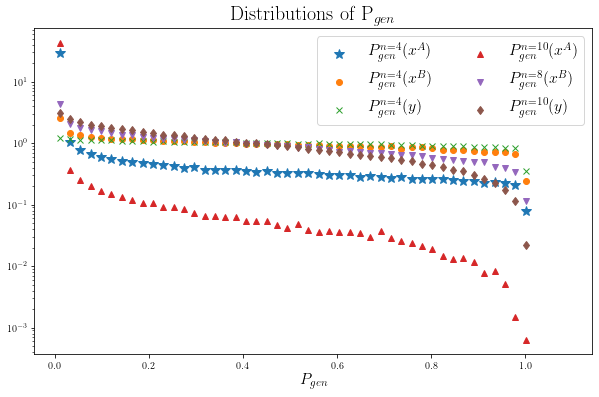

In [22]:
fig = plt.figure(figsize=(10, 6))
plt.plot(newbins,proboldVecAn4dist,label=r'$P^{n=4}_{gen}(x^A)$', marker = '*',markersize=10,linestyle = 'None')
plt.plot(newbins,PgennewVecBn4dist,label=r'$P^{n=4}_{gen}(x^B)$',marker = "o",linestyle = 'None')
plt.plot(newbins,probnewVecAn4dist,label=r'$P^{n=4}_{gen}(y)$',marker = "x",linestyle = 'None')

plt.plot(newbins,proboldVecAn10dist,label=r'$P^{n=10}_{gen}(x^A)$',marker = "^",linestyle = 'None')
plt.plot(newbins,PgennewVecBn10dist,label=r'$P^{n=8}_{gen}(x^B)$',marker = "v",linestyle = 'None')
plt.plot(newbins,probnewVecAn10dist,label=r'$P^{n=10}_{gen}(y)$',marker = "d",linestyle = 'None')

plt.yscale('log')
plt.xlabel(r'$P_{gen}$',fontsize=16)
plt.title(r'Distributions of P$_{gen}$',fontsize=20)
plt.legend(fontsize=16,ncol=2)

plt.show()


### 3.3 Figure P_gen BM3 <a name="FigPgenBM3"></a>

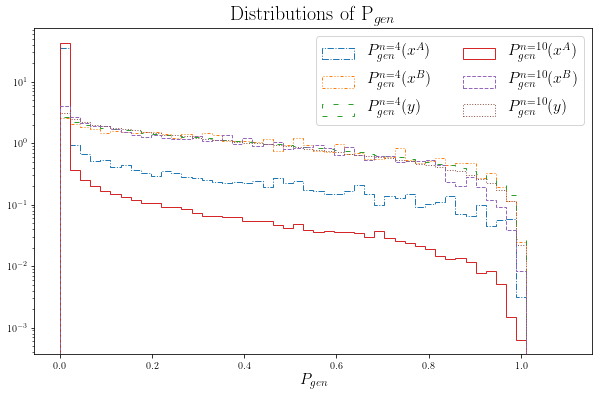

In [23]:
alphaA_zstatsn4 = np.load('data/BM3_AlgoA_NMC=1e+06_dxMax=1.5708_n=4_zstats.npy')
alphaB_zstatsn4 = np.load('data/BM3_AlgoB_NMC=1e+06_dxMax=1.5708_n=4_zstats.npy')
alphaA_zstatsn10 = np.load('data/BM3_AlgoA_NMC=1e+06_dxMax=1.5708_n=10_zstats.npy')
alphaB_zstatsn10 = np.load('data/BM3_AlgoB_NMC=100000_dxMax=1.5708_n=10_zstats.npy')

proboldVecAn4 = alphaA_zstatsn4[0]
probnewVecAn4 = alphaA_zstatsn4[1]
PtargoldVecAn4 = alphaA_zstatsn4[2]
PtargnewVecAn4 = alphaA_zstatsn4[3]

zAn4 = PtargnewVecAn4/PtargnewVecAn4 * proboldVecAn4 / probnewVecAn4

proboldVecBn4 = alphaB_zstatsn4[0]
probnewVecBn4 = alphaB_zstatsn4[1]
PtargoldVecAn4  = alphaB_zstatsn4[2]
PtargnewVecBn4 = alphaB_zstatsn4[3]
PgennewVecBn4 = alphaB_zstatsn4[4]

zBn4 = PtargnewVecBn4/PtargnewVecBn4 * proboldVecBn4 / probnewVecBn4

proboldVecAn10 = alphaA_zstatsn10[0]
probnewVecAn10 = alphaA_zstatsn10[1]
PtargoldVecAn10 = alphaA_zstatsn10[2]
PtargnewVecAn10 = alphaA_zstatsn10[3]

zAn10 = PtargnewVecAn10/PtargnewVecAn10 * proboldVecAn10 / probnewVecAn10

proboldVecBn10 = alphaB_zstatsn10[0]
probnewVecBn10 = alphaB_zstatsn10[1]
PtargoldVecAn10  = alphaB_zstatsn10[2]
PtargnewVecBn10 = alphaB_zstatsn10[3]
PgennewVecBn10 = alphaB_zstatsn10[4]

zBn10 = PtargnewVecBn10/PtargnewVecBn10 * proboldVecBn10 / probnewVecBn10

for i in range(len(zAn4)):
    if zAn4[i]>1:
        zAn4[i]=1

for i in range(len(zBn4)):
    if zBn4[i]>1:
        zBn4[i]=1

for i in range(len(zAn10)):
    if zAn10[i]>1:
        zAn10[i]=1

for i in range(len(zBn10)):
    if zBn10[i]>1:
        zBn10[i]=1
        
fig = plt.figure(figsize=(10, 6))
proboldVecAn4dist, bins, patches = pyplot.hist(proboldVecAn4,bins=50,density=True,label=r'$P^{n=4}_{gen}(x^A)$',histtype='step',linestyle=('dashdot'),range=(0,1.1))
PgennewVecBn4dist, bins, patches = pyplot.hist(PgennewVecBn4,bins=50,density=True,label=r'$P^{n=4}_{gen}(x^B)$',histtype='step',linestyle=((0, (3, 2, 1, 2, 1,2))),range=(0,1.1))
probnewVecAn4dist, bins, patches = pyplot.hist(probnewVecAn4,bins=50,density=True,label=r'$P^{n=4}_{gen}(y)$',histtype='step',linestyle=((0, (5, 10))),range=(0,1.1))
#pyplot.hist(zAn4,bins=100,density=True,label=r'$z_A^{n=4}$',histtype='step')
proboldVecAn10dist, bins, patches = pyplot.hist(proboldVecAn10,bins=50,density=True,label=r'$P^{n=10}_{gen}(x^A)$',histtype='step',linestyle=('solid'),range=(0,1.1))
PgennewVecBn10dist, bins, patches = pyplot.hist(PgennewVecBn10,bins=50,density=True,label=r'$P^{n=10}_{gen}(x^B)$',histtype='step',linestyle=('dashed'),range=(0,1.1))
probnewVecAn10dist, bins, patches = pyplot.hist(probnewVecAn10,bins=50,density=True,label=r'$P^{n=10}_{gen}(y)$',histtype='step',linestyle=('dotted'),range=(0,1.1))
#pyplot.hist(zAn10,bins=100,density=True,label=r'$z_A^{n=10}$',histtype='step')

plt.yscale('log')
plt.xlabel(r'$P_{gen}$',fontsize=16)
plt.title(r'Distributions of P$_{gen}$',fontsize=20)
plt.legend(fontsize=16,ncol=2)

newbins= bins- (bins[1]-bins[0])/2
newbins=newbins[1:]

plt.show()


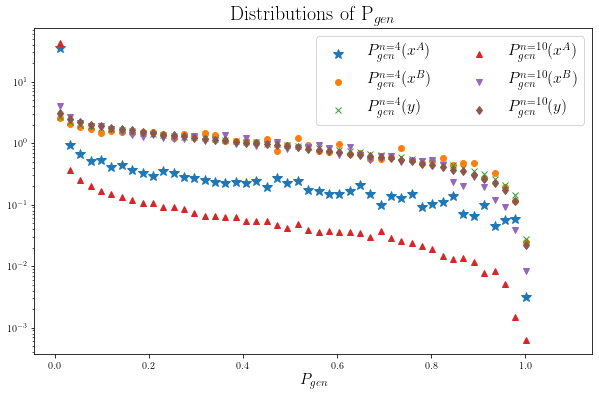

In [24]:
fig = plt.figure(figsize=(10, 6))
plt.plot(newbins,proboldVecAn4dist,label=r'$P^{n=4}_{gen}(x^A)$', marker = '*',markersize=10,linestyle = 'None')
plt.plot(newbins,PgennewVecBn4dist,label=r'$P^{n=4}_{gen}(x^B)$',marker = "o",linestyle = 'None')
plt.plot(newbins,probnewVecAn4dist,label=r'$P^{n=4}_{gen}(y)$',marker = "x",linestyle = 'None')

plt.plot(newbins,proboldVecAn10dist,label=r'$P^{n=10}_{gen}(x^A)$',marker = "^",linestyle = 'None')
plt.plot(newbins,PgennewVecBn10dist,label=r'$P^{n=10}_{gen}(x^B)$',marker = "v",linestyle = 'None')
plt.plot(newbins,probnewVecAn10dist,label=r'$P^{n=10}_{gen}(y)$',marker = "d",linestyle = 'None')

plt.yscale('log')
plt.xlabel(r'$P_{gen}$',fontsize=16)
plt.title(r'Distributions of P$_{gen}$',fontsize=20)
plt.legend(fontsize=16,ncol=2)

plt.show()
